In [12]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
from matplotlib.cm import get_cmap
import seaborn as sns
import warnings

from matplotlib.colors import DivergingNorm

# Experiment Parameters

In [101]:
plot_step = 0.01
width = 5
n = 1000
acc_thresh = 0.70
epochs = 10

# Data Generation
## Function

In [102]:
def generate_gaussian_parity(n):
    X = np.array([[np.random.uniform(-1, 1), np.random.uniform(-1, 1)] for _ in range(n)])
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

    random_indices_order = list(range(len(X)))
    np.random.shuffle(random_indices_order)
    return X[random_indices_order], np.array(y[random_indices_order]).astype('int')

## Training Data

In [103]:
X, y = generate_gaussian_parity(n = n)

## Grid Generation

In [104]:
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

# Construct & Train Network

In [105]:
acc = 0
while acc < acc_thresh:
  network = keras.Sequential()
  network.add(keras.layers.Dense(width, input_shape = np.shape(X)[1:], activation = 'relu', use_bias=False, kernel_initializer = 'he_normal'))
  network.add(keras.layers.Dense(width, activation = 'relu', use_bias=False, kernel_initializer = 'he_normal'))
  network.add(keras.layers.Dense(1, activation = 'sigmoid', use_bias=False, kernel_initializer = 'he_normal'))
  network.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(1e-2), metrics = ['acc'])
  network.fit(
      X, 
      y, 
      epochs = epochs, 
      verbose = False
  )

  acc = network.evaluate(X, y, verbose = False)[1]
  if acc >= acc_thresh:
    print("Done training. Acc = {:0.2f} > Acc Thresh = {:0.2f}.".format(acc, acc_thresh))
  else:
    print("Training New Network since Acc = {:0.2f} < Acc Thresh = {:0.2f}...".format(acc, acc_thresh))

Done training. Acc = 0.99 > Acc Thresh = 0.70.


## Polytope Pyramid

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: No contour levels were found within the data range.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:113: UserWarning: No contour levels were found within the data range.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:125: UserWarning: No contour levels were found within the data range.


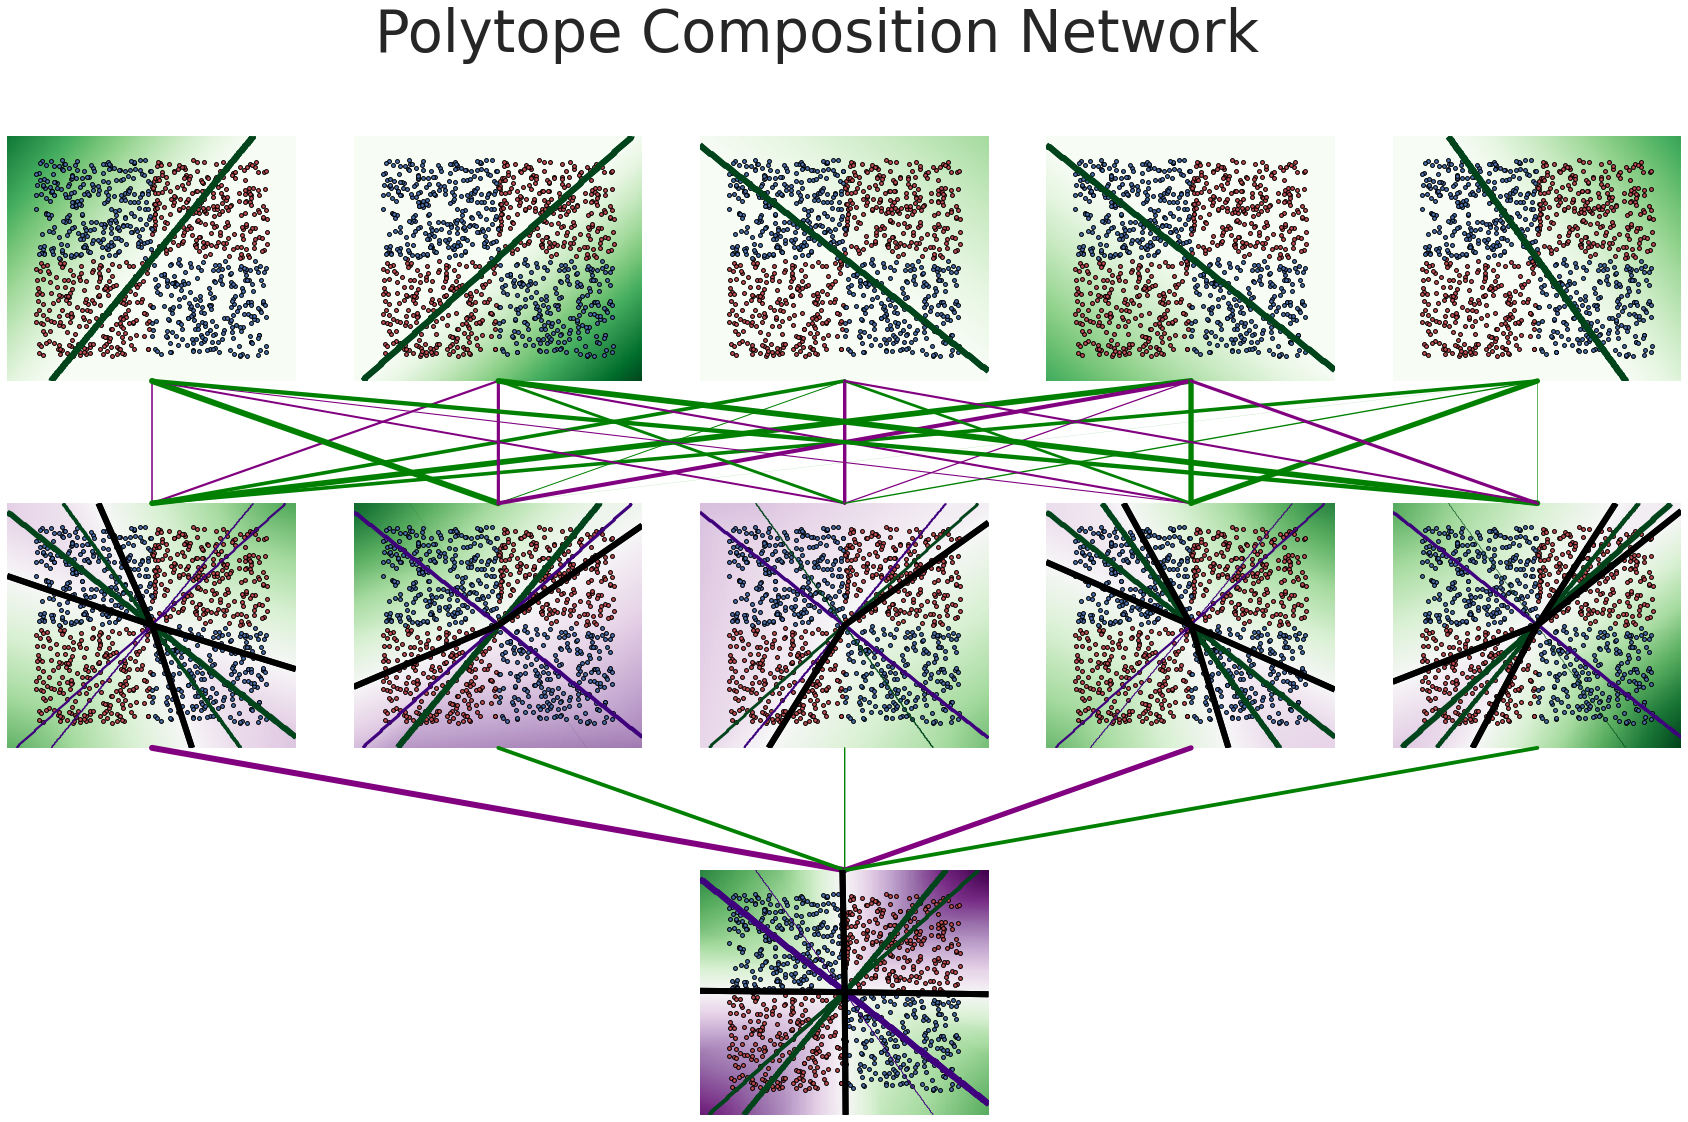

In [106]:
figs, axs = plt.subplots(3, width, figsize = (6 * width, 6 * 3))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 4)
figs.text(0.5, 0.04, '', ha='center')
figs.suptitle("Polytope Composition Network")
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)

input_weights, penultimate_weights, ultimate_weights = [network.layers[i].get_weights()[0] for i in {0, 1, 2}]
second_layer_preactivations = np.matmul(np.c_[xx.ravel(), yy.ravel()], input_weights) 
second_layer_activations = second_layer_preactivations * (second_layer_preactivations > 0).astype('int')
penultimate_preactivations = np.matmul(second_layer_activations, penultimate_weights)


    
for second_node in range(width):
    for multiplier in [-1, 1]:
      axs[0][second_node].contour(xx, 
                                yy, 
                                second_layer_activations[:, second_node].reshape(xx.shape) + multiplier * 1e-12, 
                                levels=[0], 
                                cmap="Greens",
                                vmin = -1, 
                                vmax = 0,
                                linewidths = 6)
    axs[0][second_node].pcolormesh(xx, 
                          yy, 
                          second_layer_activations[:, second_node].reshape(xx.shape), 
                          cmap="Greens", 
                          vmin = 0, 
                          vmax = np.max(second_layer_activations)
                          )
    
    # Plot the training points
    for y_val in range(2):
      idx = np.where(y == y_val)
      axs[0][second_node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                        s=15,  edgecolor = 'black')

second_polytope_widths = np.zeros(width)
for penultimate_node in range(width):
  penultimate_w_sign = np.sign(ultimate_weights[penultimate_node])
  penultimate_node_contributes = np.abs(ultimate_weights[penultimate_node]) > 1e-12 and np.max(penultimate_preactivations) > 0
  if penultimate_node_contributes:
    axs[1][penultimate_node].pcolormesh(xx, 
                              yy, 
                              penultimate_preactivations[:, penultimate_node].reshape(xx.shape),
                              cmap="PRGn", 
                              vmin = -np.max(np.abs(penultimate_preactivations)), 
                              vmax = np.max(np.abs(penultimate_preactivations))
                              )
    for multiplier in [-1, 1]:
      axs[1][penultimate_node].contour(xx, 
                              yy, 
                              penultimate_preactivations[:, penultimate_node].reshape(xx.shape) + multiplier * 1e-12,
                              cmap="Greys", 
                              levels=[0],
                              vmin = -1, 
                              vmax = 0,
                              linewidths = 6,
                              zorder = width + 1
                              )
  
  # Plot the training points
  for y_val in range(2):
    idx = np.where(y == y_val)
    axs[1][penultimate_node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                  s=15, edgecolor = 'black')

  if penultimate_node_contributes:
    con = ConnectionPatch(axesA=axs[1][penultimate_node], 
                        axesB=axs[2][int(width / 2)], 
                        xyA = [0, np.min(yy)],
                        xyB = [0, np.max(yy)],
                        coordsA="data", 
                        coordsB="data", 
                        color="green" if ultimate_weights[penultimate_node] > 0 else "purple", 
                        lw=6 * np.abs(ultimate_weights[penultimate_node]) / np.max(np.abs(ultimate_weights)))
    axs[2][int(width / 2)].add_artist(con)
    
  for second_node in range(width):
    second_w = penultimate_weights[second_node][penultimate_node] * np.sign(ultimate_weights[penultimate_node])
    second_w_sign = np.sign(second_w)
    if penultimate_node_contributes:
      xy = (1, 1)
      con = ConnectionPatch(axesA=axs[0][second_node], 
                            axesB=axs[1][penultimate_node], 
                            xyA = [0, np.min(yy)],
                            xyB = [0, np.max(yy)],
                            coordsA="data", 
                            coordsB="data", 
                            color="green" if second_w_sign * penultimate_w_sign > 0 else "purple", 
                            lw=6 * np.abs(second_w) / np.max(np.abs(penultimate_weights)))
      axs[1][penultimate_node].add_artist(con)

      axs[1][penultimate_node].contour(xx, 
                                       yy, 
                                       second_layer_activations[:, second_node].reshape(xx.shape), 
                                       levels=[0], 
                                       cmap="Greens" if second_w_sign * penultimate_w_sign > 0 else "Purples",
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6 * np.abs(second_w) / np.max(np.abs(penultimate_weights)))
      second_polytope_widths[second_node] += np.abs(ultimate_weights[penultimate_node]) * np.sign(second_w_sign)

for second_node in range(width):
    for multiplier in [-1, 1]:
      axs[2][int(width / 2)].contour(xx, 
                                       yy, 
                                       second_layer_activations[:, second_node].reshape(xx.shape) + multiplier * 1e-12, 
                                       levels=[0], 
                                       cmap="Greens" if second_polytope_widths[second_node] > 0 else "Purples",
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6 * np.abs(second_polytope_widths[second_node]) / np.max(np.abs(second_polytope_widths)))

penultimate_activations = penultimate_preactivations * (penultimate_preactivations > 0).astype('int')
ultimate_preactivations = np.matmul(penultimate_activations, ultimate_weights).reshape(xx.shape)
axs[2][int(width / 2)].pcolormesh(xx, 
                               yy, 
                               ultimate_preactivations, 
                               cmap="PRGn", 
                               vmin = -np.max(np.abs(ultimate_preactivations)), 
                               vmax = np.max(np.abs(ultimate_preactivations)))
for multiplier in [-1, 1]:
  axs[2][int(width / 2)].contour(xx, 
                               yy, 
                               ultimate_preactivations + multiplier * 1e-12, 
                               cmap="Greys", 
                               vmin = -1, 
                               vmax = 0,
                               levels=[0],
                               linewidths=6)
    
    

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  axs[2][int(width / 2)].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
              s=15, edgecolor = 'black')
plt.show()

## Polytope Pyramid

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: No contour levels were found within the data range.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:116: UserWarning: No contour levels were found within the data range.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:128: UserWarning: No contour levels were found within the data range.


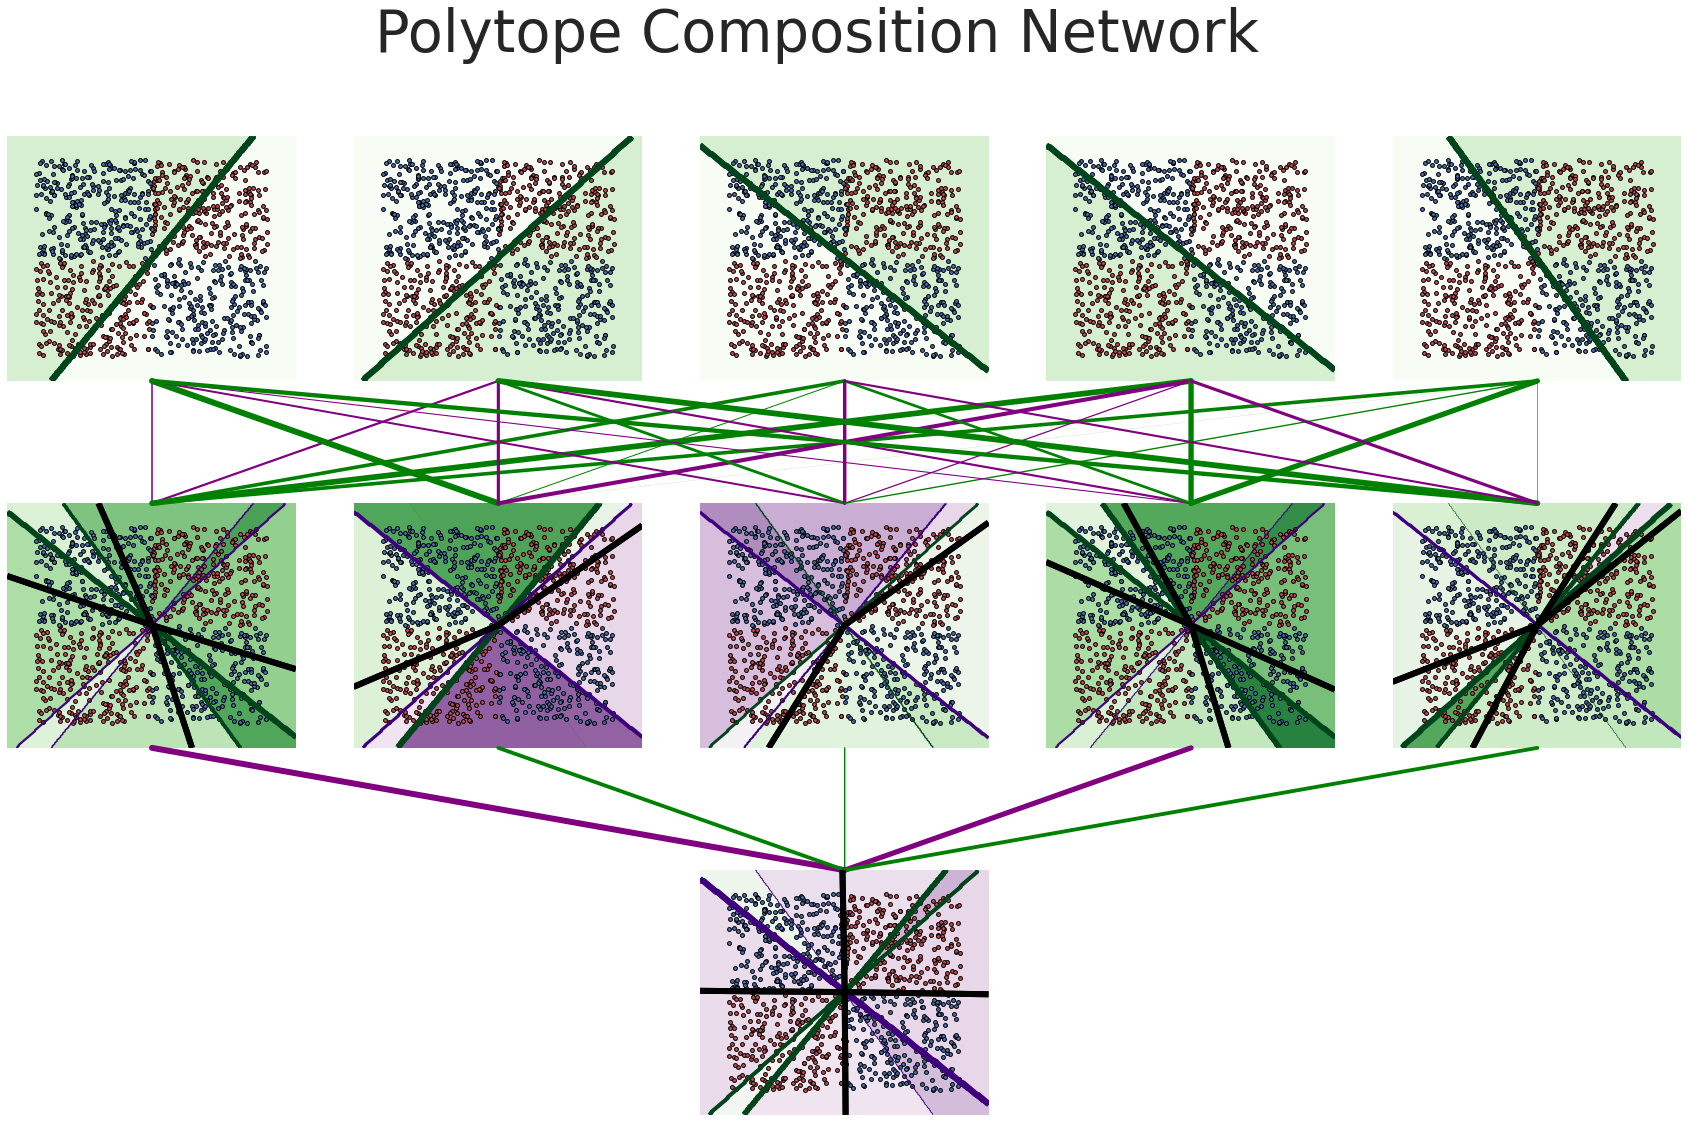

In [107]:
figs, axs = plt.subplots(3, width, figsize = (6 * width, 6 * 3))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 4)
figs.text(0.5, 0.04, '', ha='center')
figs.suptitle("Polytope Composition Network")
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)

input_weights, penultimate_weights, ultimate_weights = [network.layers[i].get_weights()[0] for i in {0, 1, 2}]
second_layer_preactivations = np.matmul(np.c_[xx.ravel(), yy.ravel()], input_weights) 
signed_second_layer_preactivations = np.sign(np.matmul(np.c_[xx.ravel(), yy.ravel()], input_weights))
second_layer_activations = second_layer_preactivations * (second_layer_preactivations > 0).astype('int')
signed_second_layer_activations = signed_second_layer_preactivations * (second_layer_preactivations > 0).astype('int')
penultimate_preactivations = np.matmul(second_layer_activations, penultimate_weights)
signed_penultimate_preactivations = np.matmul(signed_second_layer_activations, penultimate_weights)


    
for second_node in range(width):
    for multiplier in [-1, 1]:
      axs[0][second_node].contour(xx, 
                                yy, 
                                signed_second_layer_activations[:, second_node].reshape(xx.shape) + multiplier * 1e-12, 
                                levels=[0], 
                                cmap="Greens",
                                vmin = -1, 
                                vmax = 0,
                                linewidths = 6)
    axs[0][second_node].pcolormesh(xx, 
                          yy, 
                          signed_second_layer_activations[:, second_node].reshape(xx.shape), 
                          cmap="Greens", 
                          vmin = 0, 
                          vmax = np.max(second_layer_activations)
                          )
    
    # Plot the training points
    for y_val in range(2):
      idx = np.where(y == y_val)
      axs[0][second_node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                        s=15,  edgecolor = 'black')

second_polytope_widths = np.zeros(width)
for penultimate_node in range(width):
  penultimate_w_sign = np.sign(ultimate_weights[penultimate_node])
  penultimate_node_contributes = np.abs(ultimate_weights[penultimate_node]) > 1e-12 and np.max(penultimate_preactivations) > 0
  if penultimate_node_contributes:
    axs[1][penultimate_node].pcolormesh(xx, 
                              yy, 
                              signed_penultimate_preactivations[:, penultimate_node].reshape(xx.shape),
                              cmap="PRGn", 
                              vmin = -np.max(np.abs(signed_penultimate_preactivations)), 
                              vmax = np.max(np.abs(signed_penultimate_preactivations))
                              )
    for multiplier in [-1, 1]:
      axs[1][penultimate_node].contour(xx, 
                              yy, 
                              penultimate_preactivations[:, penultimate_node].reshape(xx.shape) + multiplier * 1e-12,
                              cmap="Greys", 
                              levels=[0],
                              vmin = -1, 
                              vmax = 0,
                              linewidths = 6,
                              zorder = width + 1
                              )
  
  # Plot the training points
  for y_val in range(2):
    idx = np.where(y == y_val)
    axs[1][penultimate_node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                  s=15, edgecolor = 'black')

  if penultimate_node_contributes:
    con = ConnectionPatch(axesA=axs[1][penultimate_node], 
                        axesB=axs[2][int(width / 2)], 
                        xyA = [0, np.min(yy)],
                        xyB = [0, np.max(yy)],
                        coordsA="data", 
                        coordsB="data", 
                        color="green" if ultimate_weights[penultimate_node] > 0 else "purple", 
                        lw=6 * np.abs(ultimate_weights[penultimate_node]) / np.max(np.abs(ultimate_weights)))
    axs[2][int(width / 2)].add_artist(con)
    
  for second_node in range(width):
    second_w = penultimate_weights[second_node][penultimate_node] * np.sign(ultimate_weights[penultimate_node])
    second_w_sign = np.sign(second_w)
    if penultimate_node_contributes:
      xy = (1, 1)
      con = ConnectionPatch(axesA=axs[0][second_node], 
                            axesB=axs[1][penultimate_node], 
                            xyA = [0, np.min(yy)],
                            xyB = [0, np.max(yy)],
                            coordsA="data", 
                            coordsB="data", 
                            color="green" if second_w_sign * penultimate_w_sign > 0 else "purple", 
                            lw=6 * np.abs(second_w) / np.max(np.abs(penultimate_weights)))
      axs[1][penultimate_node].add_artist(con)

      axs[1][penultimate_node].contour(xx, 
                                       yy, 
                                       signed_second_layer_activations[:, second_node].reshape(xx.shape), 
                                       levels=[0], 
                                       cmap="Greens" if second_w_sign * penultimate_w_sign > 0 else "Purples",
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6 * np.abs(second_w) / np.max(np.abs(penultimate_weights)))
      second_polytope_widths[second_node] += np.abs(ultimate_weights[penultimate_node]) * np.sign(second_w_sign)

for second_node in range(width):
    for multiplier in [-1, 1]:
      axs[2][int(width / 2)].contour(xx, 
                                       yy, 
                                       signed_second_layer_activations[:, second_node].reshape(xx.shape) + multiplier * 1e-12, 
                                       levels=[0], 
                                       cmap="Greens" if second_polytope_widths[second_node] > 0 else "Purples",
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6 * np.abs(second_polytope_widths[second_node]) / np.max(np.abs(second_polytope_widths)))

signed_penultimate_activations = signed_penultimate_preactivations * (signed_penultimate_preactivations > 0).astype('int')
signed_ultimate_preactivations = np.matmul(signed_penultimate_activations, ultimate_weights).reshape(xx.shape)
axs[2][int(width / 2)].pcolormesh(xx, 
                               yy, 
                               signed_ultimate_preactivations, 
                               cmap="PRGn", 
                               vmin = -np.max(np.abs(ultimate_preactivations)), 
                               vmax = np.max(np.abs(ultimate_preactivations)))
for multiplier in [-1, 1]:
  axs[2][int(width / 2)].contour(xx, 
                               yy, 
                               ultimate_preactivations + multiplier * 1e-12, 
                               cmap="Greys", 
                               vmin = -1, 
                               vmax = 0,
                               levels=[0],
                               linewidths=6)
    
    

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  axs[2][int(width / 2)].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
              s=15, edgecolor = 'black')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: No contour levels were found within the data range.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:40: UserWarning: No contour levels were found within the data range.


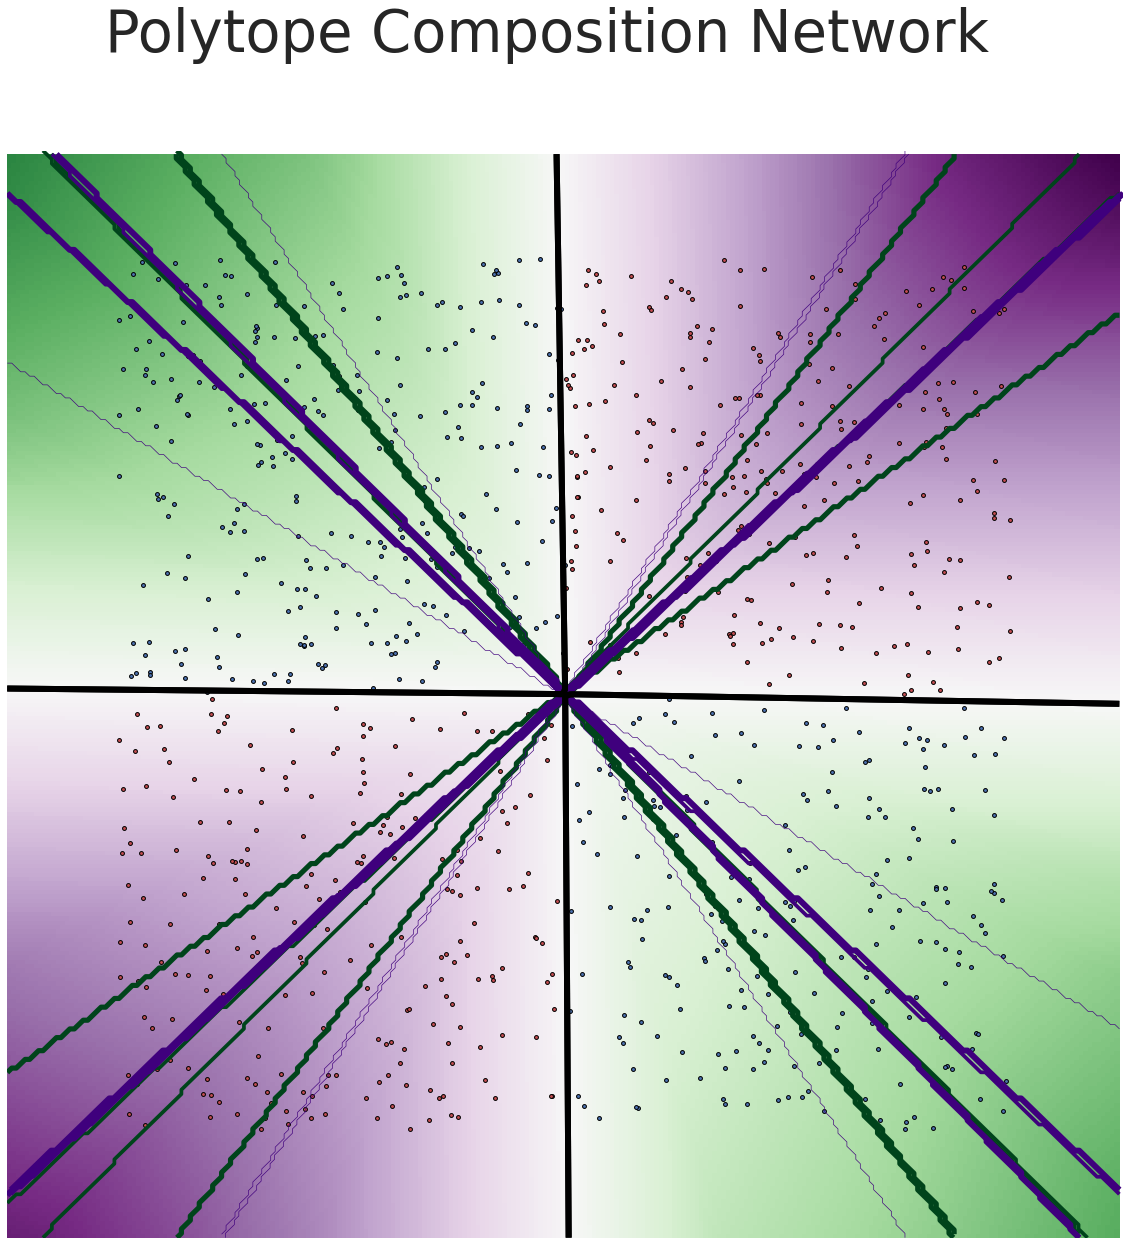

In [109]:
figs, axs = plt.subplots(1, 1, figsize = (20, 20))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 4)
figs.text(0.5, 0.04, '', ha='center')
figs.suptitle("Polytope Composition Network")
figs.set_facecolor('white')

axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel('')
axs.set_ylabel('')
axs.label_outer()
axs.set_facecolor('white')

for side in {"right", "left", "top", "bottom"}:
    axs.spines[side].set_visible(False)

input_weights, penultimate_weights, ultimate_weights = [network.layers[i].get_weights()[0] for i in {0, 1, 2}]
second_layer_preactivations = np.matmul(np.c_[xx.ravel(), yy.ravel()], input_weights) 
second_layer_activations = second_layer_preactivations * (second_layer_preactivations > 0).astype('int')
penultimate_preactivations = np.matmul(second_layer_activations, penultimate_weights)

for second_node in range(width):
    for multiplier in [[1, 1], [-1, 1], [1, -1]]:
      axs.contour(multiplier[0] * xx, 
                                       multiplier[1] * yy, 
                                       second_layer_activations[:, second_node].reshape(xx.shape), 
                                       levels=[0], 
                                       cmap="Greens" if second_polytope_widths[second_node] > 0 else "Purples",
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6 * np.abs(second_polytope_widths[second_node]) / np.max(np.abs(second_polytope_widths)))
    axs.contour(yy, 
                                       xx, 
                                       second_layer_activations[:, second_node].reshape(xx.shape), 
                                       levels=[0], 
                                       cmap="Greens" if second_polytope_widths[second_node] > 0 else "Purples",
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6 * np.abs(second_polytope_widths[second_node]) / np.max(np.abs(second_polytope_widths)))

penultimate_activations = penultimate_preactivations * (penultimate_preactivations > 0).astype('int')
ultimate_preactivations = np.matmul(penultimate_activations, ultimate_weights).reshape(xx.shape)
axs.pcolormesh(xx, 
                               yy, 
                               ultimate_preactivations, 
                               cmap="PRGn", 
                               vmin = -np.max(np.abs(ultimate_preactivations)), 
                               vmax = np.max(np.abs(ultimate_preactivations)))
for multiplier in [-1, 1]:
  axs.contour(xx, 
                               yy, 
                               ultimate_preactivations + multiplier * 1e-12, 
                               cmap="Greys", 
                               vmin = -1, 
                               vmax = 0,
                               levels=[0],
                               linewidths=6)
    
    
#axs.contour(xx, yy, final_preactivations, levels=[0], cmap="Greys_r")

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  axs.scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
              s=15, edgecolor = 'black')
plt.show()